In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _operation='', label=''):
        self.data = data
        #the grad variable initialises as zero. Later we use it to store the rate of changeof L with respect to this node.
        #a gradient/ slope/ rate of change of zero of L with respect to this node implies this node does not have any impact on L.
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._operation=_operation
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        #this allows us to deal with non Value objects eg the int "1" passed to the add function
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+' )

        #This is the function that defines the gradient for addition operations
        #Here we are setting the grads of the two children nodes to be 1.0 times the value of the parent node
        #IE we are saying that where c = a + b, dc/da and dc/db will just be 1.0
        #Then we are multiplying that by the gradient of the parent node, such that if c's parent node was L, and we wanted to see the impact that
        #a change in the values of a or b would have on the value of L, we would need dL/da, which can be obtained by 
        #dL/da = dL/dc * dc/da. Since we know the value of dL/dc at this point (out.grad) we just multiply that by dc/da,
        #which for a pure addition operation will always just be 1.0
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*' )

        def _backward():
            #e=a*b
            #de/da = b
            #dL/da = dL/de * de/da
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int,float)) #only supporting int/ floats for now
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad

        out._backward = _backward
        return out

    
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    # turns self inot -self
    def __neg__(self):
        return self * -1

    #subtraction
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x=self.data
        t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        #The above code defines t as the representative function of tanh(x)
        #The derivative of tanh(x) is (1-tanh^2(x))
        #So in the _backward function below t replaces tanh(x), such that the local derivative is (1-t^2)
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    # this function is e^self
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # the derivative of e^x is just e^x

        out._backward = _backward
        return out


    
    def backward(self):
        #Set the initial grad to be 1.0 because naturally whatever adjustment you make influences the final value directly by the amount of that adjustment.
        #IE if you add 0.5 directly to the final value, it will increase by 1.0 (the grad) * 0.5 = 0.5
        self.grad = 1.0
        
        topo =[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
d

Value(data=4.0)

In [3]:
a= Value(2.0)
b= Value(4.0)
a-b-a

Value(data=-4.0)

In [4]:
from graphviz import Digraph

def trace(root):
    #create a set of all the nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})#LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._operation:
            dot.node(name = uid + n._operation, label = n._operation)
            dot.edge(uid + n._operation, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot



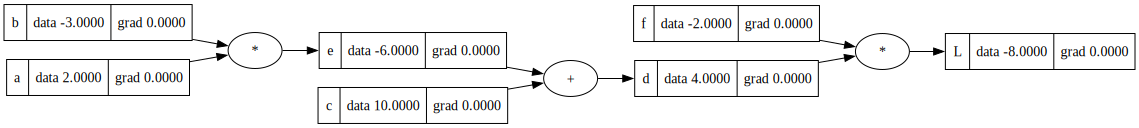

In [5]:
draw_dot(L)

In [6]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value (0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1, x2*w2
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 +b ; n.label = 'n'

e = (2*n).exp()
o = (e -1)/(e +1)

o.label = 'o'

o.backward()


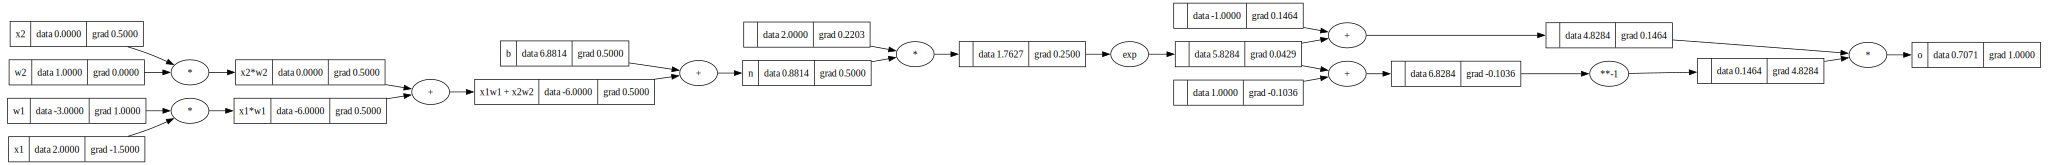

In [7]:
draw_dot(o)

In [8]:
import torch

In [9]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [10]:
class Neuron:

    def __init__(self, nin): #nin = Number of inputs = Number of dimensions of each of these neurons
        self.w = [Value(random.uniform(-1,1)) for _ in range (nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x): #invoked for Neuron object titled 'n' using n(x)
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    #gather up all the parameters of the neural net
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout): #nout is the number of neurons we want in our output (ie in our layer)
        self.neurons = [Neuron(nin) for _ in range (nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) ==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    #the length of the list in nouts below is the number of layers (except the input layer) that our NN will have
    #the values in the list represent the number of neurons associated with each layer
    #So instanciating an MLP(3,[4,4,1]) means it will take in inputs with 3 values, and have 2 layers of 4 neurons and a final layer of 1 neuron
    def __init__(self, nin, nouts):#notably nouts is a list of "nout"s, this will define the sizes of all the layers we want in our MLP
        sz = [nin] + nouts
        self.layers=[Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

        

In [11]:
q = [2.0, 3.0, 1.0]
n = MLP(3,[4,4,1])
n(q)

Value(data=-0.033027686568210236)

In [12]:
xs = [
    [2.0, 3.0,-1.0],
    [3.0, -1.0, 0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
] # inputs
ys = [1.0, -1.0, 1.0, -1.0] # targets


#each of the below outputs is the output of one forward pass of the full neural net

In [51]:
for k in range(20):
    #ypred is our forward pass
    ypred = [n(x) for x in xs]
    
    #ygt = y groud truth, ie the target y, what the output of y should be
    #ypred & yout are the values the neural network is outputting for those inputs
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    #******REMEMBER TO ZERO GRAD******
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update (learn/ descend)

    #Note the fact 0.01 is negative that is because the gradients of the neurons point in the direction (either pos or neg) that maximise the function.
    #Think about if dy/dx >0; as x increases so does the function y, therefore if we want to decrease the function we must go in the opposite direction.
    #Also note that the 0.01 here is what's known as the "step size".
    #The step size is hella important as if you make it too large (eg 0.1) you can over shoot the local minimum point, and if you make it too
    #small you will take a zillion years to reach the local minimum point of the loss function.
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 0.0008714347499964386
1 0.0008701650412659708
2 0.000868898904224417
3 0.0008676363240256008
4 0.0008663772859049011
5 0.0008651217751786621
6 0.0008638697772436971
7 0.0008626212775766551
8 0.0008613762617335671
9 0.0008601347153492522
10 0.0008588966241367918
11 0.0008576619738870275
12 0.0008564307504680027
13 0.0008552029398244492
14 0.0008539785279772862
15 0.000852757501023085
16 0.0008515398451335919
17 0.000850325546555194
18 0.0008491145916084129
19 0.0008479069666874441


In [52]:
ypred

[Value(data=0.9827751305589595),
 Value(data=-0.9949546165315886),
 Value(data=0.9875221682120677),
 Value(data=-0.9807630912318195)]